In [45]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid 
from sklearn.model_selection import train_test_split

In [46]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='data/Planetoid/Cora', name='Cora')

In [47]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/PubMed', name='PubMed')


In [48]:
data = dataset[0]  

G = to_networkx(data, to_undirected=True) 

In [49]:
G.adjacency()

In [50]:
noice=G.number_of_nodes()

In [51]:
G.number_of_nodes()

19717

In [52]:
import networkx as nx
from networkx.algorithms.clique import find_cliques
max=G.number_of_nodes()
cliques = list(find_cliques(G))
lol =dict()
virtual_nodes = dict()
print(f"Number of cliques in the Karate Club graph: {len(cliques)}")
for i, clique in enumerate(cliques):
    if len(clique)==3:
        #rule1
        lol[max]=clique  
        #rule2
        virtual_nodes[max]=clique
        flag=clique
        for j in clique:
            virtual_nodes[max]=virtual_nodes[max]+list(G.neighbors(j))
            # flag=flag+list(G.neighbors(j))
        virtual_nodes[max]=list(set(virtual_nodes[max]))        
        print(f"Clique {max}: {clique}")
        print(f"Node {max} has neighbors: {virtual_nodes[max]}")
        max=max+1




Number of cliques in the Karate Club graph: 37305
Clique 19717: [0, 1544, 1378]
Node 19717 has neighbors: [0, 6145, 12160, 11651, 17412, 9861, 11142, 1544, 1290, 17277, 15503, 16527, 9234, 7443, 10259, 19349, 17687, 8602, 18459, 2078, 14502, 18855, 678, 12972, 16684, 14896, 14770, 16822, 1720, 2110, 704, 18242, 12360, 12746, 6092, 6733, 17102, 16976, 1233, 9809, 7379, 7636, 3541, 4048, 15314, 13272, 16217, 6106, 13662, 10976, 1378, 8931, 99, 12643, 10087, 10088, 10216, 14442, 4203, 10728, 8302, 4976, 6769, 10740, 12280, 12925, 18814]
Clique 19718: [0, 1544, 6092]
Node 19718 has neighbors: [0, 7297, 12160, 11651, 17412, 9861, 16772, 1544, 1290, 7191, 17687, 18459, 2078, 17054, 14502, 18855, 2344, 10665, 12972, 16684, 16822, 2110, 1728, 18242, 12103, 12360, 6092, 6733, 17102, 16976, 1233, 9809, 7379, 7636, 3541, 13272, 6106, 13662, 10976, 1378, 8931, 99, 12643, 10087, 10088, 10216, 14442, 8302, 4976, 6769, 10740, 12280, 15099, 17277, 18814]
Clique 19719: [0, 14442, 7636]
Node 19719 has n

In [53]:
#rule3
count=0
for i in lol.keys():
    for j in lol.keys():
        if i!=j:
            if set(lol[i]).issubset(lol[j]):
                count=count+1
                virtual_nodes[i].append(j)
                virtual_nodes[j].append(i)
print(count)

0


In [54]:
for i in virtual_nodes.keys():
    for j in virtual_nodes[i]:
        G.add_edge(i,j) 

In [55]:
G.number_of_nodes()

26142

In [56]:
print(f'Number of nodes: {dataset[0].num_nodes}')

Number of nodes: 19717


KeyboardInterrupt: 

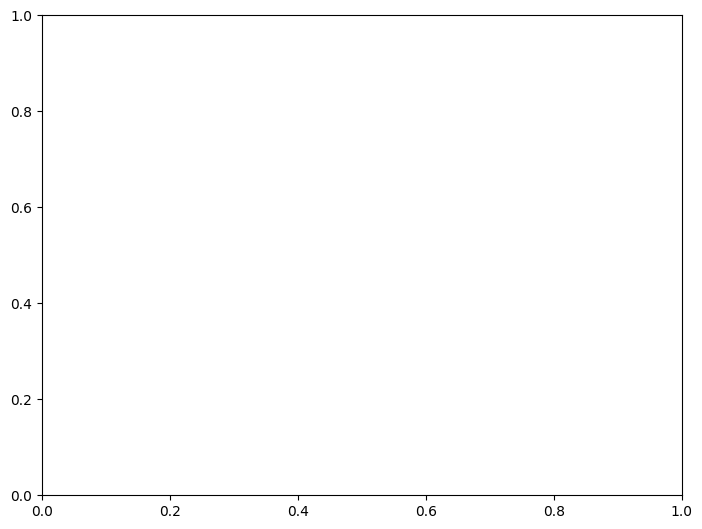

In [57]:
node_color = ['yellow' if node_id > noice  else 'red' for node_id in G]


nx.draw(G, node_color=node_color, with_labels=True)
plt.show()

feature aggrigation


In [58]:
x=torch.zeros(1433)

In [60]:
for i in lol:
    x=torch.zeros(500)
    for j in lol[i]:
        x=data.x[j]+x
    data.x=torch.cat((data.x,x.unsqueeze(0)),0)

In [61]:
data.edge_index

tensor([[ 1378,  1544,  6092,  ..., 12278,  4284, 16030],
        [    0,     0,     0,  ..., 19714, 19715, 19716]])

In [62]:
edge_list=nx.to_edgelist(G)
edge_index = torch.tensor([[edge[0], edge[1]] for edge in edge_list], dtype=torch.long).t().contiguous()
print(edge_index)

tensor([[    0,     0,     0,  ..., 19715, 19715, 19715],
        [ 1378,  1544,  6092,  ..., 22915, 22985, 22986]])


In [63]:
data.edge_index=edge_index

Model prep

In [64]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.nn import GCNConv

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = Net()

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [65]:
embeddings = model(data.x, data.edge_index)

print(embeddings)

tensor([[-1.1085, -1.0808, -1.1068],
        [-1.0967, -1.1013, -1.0978],
        [-1.1422, -1.0989, -1.0566],
        ...,
        [-1.1610, -1.1110, -1.0284],
        [-1.1660, -1.1408, -0.9974],
        [-1.1606, -1.1532, -0.9914]], grad_fn=<LogSoftmaxBackward0>)


In [66]:
embeddings.shape

torch.Size([26142, 3])

In [67]:
G.number_of_nodes()

26142